In [1]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import cv2
import os
import re

<h1>Load Dataset and feature Matrix</h1>

In [2]:
# images = pd.read_csv('../Ages.csv')
images = pd.read_csv('../../Assignment 1/task1/Data.csv')

In [3]:
# file_name = '../Compressed_data_age_1'
file_name = '../../Assignment 1/task1/Compressed_data_1'
with open(file_name, 'rb') as handle:
    feature_matrix = pkl.load(handle)
print(feature_matrix.shape)

(61, 3072)


In [4]:
X_train,X_test,y_train,y_test = train_test_split(feature_matrix,images['age'],test_size=0.2)

In [5]:
X_train.shape,X_test.shape

((48, 3072), (13, 3072))

In [6]:
reg = SGDRegressor(random_state=10,early_stopping=True)

In [7]:
params = {'alpha':[0.0001,0.001,0.003,0.01,0.03,0.1],'penalty':['l2','l1'],'l1_ratio':[0,0.1,0.15,0.18],'max_iter':[1000,2000],'loss':['huber']}

In [8]:
searcher = GridSearchCV(reg,param_grid=params,cv=10,scoring='r2',n_jobs=-1)

In [9]:
searcher.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=SGDRegressor(early_stopping=True, random_state=10),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.003, 0.01, 0.03, 0.1],
                         'l1_ratio': [0, 0.1, 0.15, 0.18], 'loss': ['huber'],
                         'max_iter': [1000, 2000], 'penalty': ['l2', 'l1']},
             scoring='r2')

In [10]:
y_pred = searcher.predict(X_test)
reg = searcher.best_estimator_

In [11]:
# reg.fit(X_train,y_train)

In [12]:
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

In [13]:
mse_test = MSE(y_test,y_pred_test)
mse_train = MSE(y_train,y_pred_train)

rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train) 

In [14]:
# model_file = 'SGF_Linear_Reg_Images_UTKFace.sav'
model_file = 'SGF_Linear_Reg_Images_my_data.sav'
pkl.dump(reg,open(model_file,'wb'))

In [15]:
# model_file = 'SGF_Linear_Reg_Images_UTKFace.sav'
model_file = 'SGF_Linear_Reg_Images_my_data.sav'
reg = pkl.load(open(model_file,'rb'))

<h1 style='text-align:center'>Model evaluation</h1>

Linear Regression 
<br>
Mean squared error 0.5069245345783313
<br>
Root mean squared error: 0.7119863303310895


In [16]:
print(f'Parameters: {reg.get_params()}')
print(f'Coefficient: {reg.coef_}')
print(f'Intercept: {reg.intercept_}')
print(f'Mean squared error test: {mse_test}')
print(f'Mean squared error train: {mse_train}')
print(f'Root mean squared error train: {rmse_train}')
print(f'Root mean squared error test: {rmse_test}')

Parameters: {'alpha': 0.0001, 'average': False, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0, 'learning_rate': 'invscaling', 'loss': 'huber', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': 10, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Coefficient: [0.01916351 0.02159493 0.01894556 ... 0.00933232 0.00792678 0.00747847]
Intercept: [0.04906259]
Mean squared error test: 9.542365097105279
Mean squared error train: 12.521601890492937
Root mean squared error train: 3.5385875558608038
Root mean squared error test: 3.089071882799958


In [17]:
X_test_array_index = np.arange(1,X_test.shape[0]+1)
X_train_array_index = np.arange(1,X_train.shape[0]+1)
X_train_array_index.shape,y_test.shape

((48,), (13,))

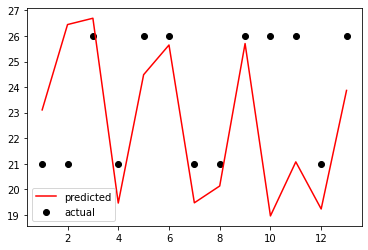

In [18]:
plt.scatter(X_test_array_index[:100],y_test[:100],color='black',label='actual')
plt.plot(X_test_array_index[:100],y_pred[:100],color='red',label='predicted')
plt.legend()
plt.plot()
plt.show()